# Imports 

In [21]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


# Load Dataset
WELFake from HuggingFace

In [3]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

Generating train split: 100%|██████████| 70793/70793 [00:00<00:00, 137474.52 examples/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length'],
        num_rows: 70793
    })
})


## Split dataset

In [19]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
print(df)

                                                    text  label  has_quotes  \
0      No comment is expected from Barack Obama Membe...      1           0   
1       Now, most of the demonstrators gathered last ...      1           0   
2      A dozen politically active pastors came here f...      0           0   
3      The RS-28 Sarmat missile, dubbed Satan 2, will...      1           0   
4      All we can say on this one is it s about time ...      1           0   
...                                                  ...    ...         ...   
70788  WASHINGTON (Reuters) - Hackers believed to be ...      0           0   
70789  You know, because in fantasyland Republicans n...      1           0   
70790  Migrants Refuse To Leave Train At Refugee Camp...      0           1   
70791  MEXICO CITY (Reuters) - Donald Trump’s combati...      0           0   
70792  Goldman Sachs Endorses Hillary Clinton For Pre...      1           0   

       has_url  percent_uppercase  frequency_punctu

NB multinomial needs numeric, remove non numerics

In [22]:
# Convert dataset to pandas for easier implementation with sklearn
df = dataset["train"].to_pandas()
print("Dataset columns:", df.columns)
print("Data types:", df.dtypes)

# Check for any non-numeric values that might cause problems
for col in df.columns:
    if df[col].dtype == 'object':  # Check if column contains strings
        print(f"Column {col} contains non-numeric data and will be dropped")
        df = df.drop(columns=[col])

# Make sure all remaining columns are numeric
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError as e:
        print(f"Error converting column {col}: {e}")
        # If conversion fails, we'll examine the problematic values
        problematic_rows = df[~pd.to_numeric(df[col], errors='coerce').notna()]
        if not problematic_rows.empty:
            print(f"Sample of problematic values in {col}:")
            print(problematic_rows[col].head())
            # Drop the problematic column if we can't convert it
            df = df.drop(columns=[col])

print("Final columns after cleaning:", df.columns)

Dataset columns: Index(['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase',
       'frequency_punctuation', 'percent_whitespace',
       'frequency_words_length_15', 'frequency_words_length_14',
       'frequency_words_length_12', 'frequency_words_length_11',
       'avg_sentence_length'],
      dtype='object')
Data types: text                          object
label                          int64
has_quotes                     int64
has_url                        int64
percent_uppercase            float64
frequency_punctuation          int64
percent_whitespace           float64
frequency_words_length_15      int64
frequency_words_length_14      int64
frequency_words_length_12      int64
frequency_words_length_11      int64
avg_sentence_length          float64
dtype: object
Column text contains non-numeric data and will be dropped
Final columns after cleaning: Index(['label', 'has_quotes', 'has_url', 'percent_uppercase',
       'frequency_punctuation', 'percent_whitespace',
  

In [23]:
from sklearn.model_selection import train_test_split

seed = 45

y = df["label"]
x = df.drop(labels=["label"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

print(x_train, y_train)

       has_quotes  has_url  percent_uppercase  frequency_punctuation  \
33090           0        0           4.365983                     42   
13814           0        1           2.970607                     70   
47609           0        0           3.880804                     29   
30722           0        0           3.251016                     67   
1945            0        1           2.789491                     77   
...           ...      ...                ...                    ...   
12895           0        1           3.202995                     61   
60960           0        1           2.864939                     32   
6012            0        1          17.731959                     11   
63107           0        0           3.806452                     30   
6558            0        0           5.263158                      4   

       percent_whitespace  frequency_words_length_15  \
33090           16.362946                          0   
13814           16.8230

### Training

no further preprocessing

In [24]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

Convert Negative values to 0 and scale features to [0,1]

In [25]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

Initialize and train multinomialNB classifier

In [26]:
nb_multinomial = MultinomialNB()
nb_multinomial.fit(x_train_scaled, y_train)

MultinomialNB()

In [27]:
# Make predictions
y_pred = nb_multinomial.predict(x_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.641288226569673


In [28]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.48      0.57      7006
           1       0.61      0.79      0.69      7153

    accuracy                           0.64     14159
   macro avg       0.65      0.64      0.63     14159
weighted avg       0.65      0.64      0.63     14159



In [29]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[3395 3611]
 [1468 5685]]


## Visualize feature importance

examine log probabilities for naive Bayes

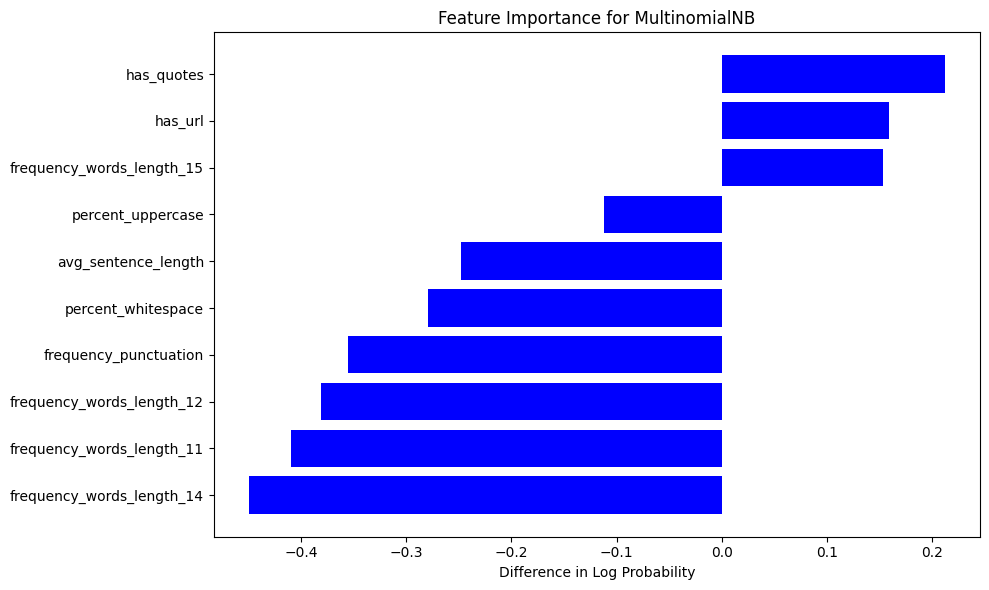

In [30]:
feature_importance = nb_multinomial.feature_log_prob_[1] - nb_multinomial.feature_log_prob_[0]
feature_names = x_train.columns

# Sort features by importance
indices = np.argsort(feature_importance)
plt.figure(figsize=(10, 6))
plt.title('Feature Importance for MultinomialNB')
plt.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Difference in Log Probability')
plt.tight_layout()
plt.show()

## Tuning alpha parameter with cross-validation

In [31]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}

# Set up GridSearchCV
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]},
             scoring='accuracy')

Compare the parameters

In [32]:
# Print best parameters
print("\nBest parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))


Best parameters found:  {'alpha': 10.0}
Best cross-validation accuracy: 0.6372


Evaluate model with best parameters

In [33]:
best_nb = grid_search.best_estimator_
y_pred_best = best_nb.predict(x_test_scaled)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Test accuracy with best parameters: {:.4f}".format(accuracy_best))

Test accuracy with best parameters: 0.6414


Save the results

In [34]:
import json
import os
from datetime import datetime

# Create a dictionary to store all results
results = {
    "model_name": "MultinomialNB",
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "dataset": "WELFake_stylo_feats",
    "metrics": {
        "accuracy": float(accuracy),
        "best_accuracy": float(accuracy_best),
        "best_alpha": grid_search.best_params_["alpha"],
        "confusion_matrix": conf_matrix.tolist(),
        "classification_report": {}
    },
    "feature_importance": {feature: float(importance) for feature, importance in 
                          zip(feature_names, feature_importance)}
}

# Get classification report metrics
report = classification_report(y_test, y_pred, output_dict=True)
for class_label, metrics in report.items():
    if isinstance(metrics, dict):
        results["metrics"]["classification_report"][class_label] = {
            k: float(v) for k, v in metrics.items()
        }

# Ensure the results directory exists
if not os.path.exists('model_results'):
    os.makedirs('model_results')

# Save the results to a JSON file
filename = f"model_results/nb_multinomial_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(filename, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {filename}")

Results saved to model_results/nb_multinomial_results_20250420_221825.json


# K-Fold Validation

In [35]:
from sklearn.model_selection import cross_val_score, KFold

# Setup k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Create a new MultinomialNB classifier with the best alpha from grid search
best_alpha = grid_search.best_params_['alpha']
nb_cv = MultinomialNB(alpha=best_alpha)

# Perform k-fold cross-validation
cv_scores = cross_val_score(nb_cv, x_train_scaled, y_train, cv=kf, scoring='accuracy')

# Print cross-validation results
print(f"K-fold Cross-Validation Results ({k_folds} folds):")
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"Individual fold scores: {cv_scores}")

# Train the final model on the entire training dataset
nb_final = MultinomialNB(alpha=best_alpha)
nb_final.fit(x_train_scaled, y_train)

K-fold Cross-Validation Results (5 folds):
CV Accuracy: 0.6371 ± 0.0040
Individual fold scores: [0.64085813 0.63308908 0.6335305  0.63503134 0.64294544]


MultinomialNB(alpha=10.0)

# Test on the gossicop dataset

In [43]:
# Load the external test dataset
from datasets import load_dataset
import pandas as pd
import numpy as np

external_test = load_dataset("lelexuanzz/Gossipcop_Politifact_Test_Stylo")
test_df = external_test["train"].to_pandas()

# Prepare the test features and labels
X_external = test_df.drop(columns=['label', 'text'])
y_external = test_df['label']

# Print shapes and feature names for debugging
print(f"Training features shape: {x_train_scaled.shape}")
print(f"External test features shape: {X_external.shape}")

# When the scaler isn't working, create a new one for the external data
# This avoids cross-dataset compatibility issues while still normalizing the data
external_scaler = MinMaxScaler()
X_external_scaled = external_scaler.fit_transform(X_external)

# Or alternatively, manually scale the features to the same range
# X_external_scaled = (X_external - X_external.min()) / (X_external.max() - X_external.min())

# Make predictions on the external test set
external_predictions = nb_final.predict(X_external_scaled)

# Evaluate performance on the external test set
external_accuracy = accuracy_score(y_external, external_predictions)
external_report = classification_report(y_external, external_predictions)
external_conf_matrix = confusion_matrix(y_external, external_predictions)

print("\nPerformance on external test dataset:")
print(f"Accuracy: {external_accuracy:.4f}")
print("Classification Report:")
print(external_report)
print("Confusion Matrix:")
print(external_conf_matrix)

Training features shape: (56634, 10)
External test features shape: (6900, 10)

Performance on external test dataset:
Accuracy: 0.6030
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      4568
           1       0.42      0.45      0.44      2332

    accuracy                           0.60      6900
   macro avg       0.56      0.57      0.56      6900
weighted avg       0.61      0.60      0.61      6900

Confusion Matrix:
[[3101 1467]
 [1272 1060]]


# Feature Selection

In [38]:
from sklearn.feature_selection import SelectKBest, f_classif

# Remove the text column if present in your x_train dataset
features_for_selection = x_train.drop('text', axis=1, errors='ignore')

# Define the number of top features to select
num_features = 5  # You can adjust this number

# Use SelectKBest to identify top features
selector = SelectKBest(f_classif, k=num_features)
selector.fit(features_for_selection, y_train)

# Get selected feature indices and names
selected_indices = selector.get_support(indices=True)
selected_features = features_for_selection.columns[selected_indices]

print(f"\nTop {num_features} selected features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature} (Score: {selector.scores_[selected_indices[i]]:.2f})")

# Create datasets with only selected features
X_train_selected = features_for_selection.iloc[:, selected_indices]
X_test_selected = x_test.drop('text', axis=1, errors='ignore').iloc[:, selected_indices]

# Scale the selected features
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

# Train and evaluate model with selected features
nb_selected = MultinomialNB(alpha=best_alpha)
nb_selected.fit(X_train_selected_scaled, y_train)
selected_predictions = nb_selected.predict(X_test_selected_scaled)

# Evaluate performance with selected features
selected_accuracy = accuracy_score(y_test, selected_predictions)
selected_report = classification_report(y_test, selected_predictions)

print("\nPerformance with selected features:")
print(f"Accuracy: {selected_accuracy:.4f}")
print("Classification Report:")
print(selected_report)


Top 5 selected features:
1. has_quotes (Score: 265.64)
2. has_url (Score: 5211.61)
3. percent_uppercase (Score: 738.76)
4. frequency_words_length_15 (Score: 232.28)
5. avg_sentence_length (Score: 226.24)

Performance with selected features:
Accuracy: 0.6421
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.48      0.57      7006
           1       0.61      0.80      0.69      7153

    accuracy                           0.64     14159
   macro avg       0.66      0.64      0.63     14159
weighted avg       0.66      0.64      0.63     14159

